# Introduction

The objective of this notebook is to build a binary classifier that can detect diabetic retinopathy on a fundus image.

# Setup

In [ ]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
from tqdm import tqdm

import cv2

from skimage.io import imread, imshow
from skimage.transform import resize

from PIL import Image

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                        ModelCheckpoint, CSVLogger)
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
  tf.config.experimental.set_memory_growth(device, True)

In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3

In [ ]:
# check how many images
base_path= '/content/drive/MyDrive/Data science/Tensorflow/Projects/diabetic blindness/data/'
train_path =  base_path + 'train_images/'
test_path = base_path + 'test_images/'
train_csv = base_path + 'train.csv'
test_csv = base_path + 'test.csv'

train_list = os.listdir(train_path)
test_list = os.listdir(test_path)

print('training images #: ', len(train_list))
print('test images #: ', len(test_list))
print(train_list[0])

training images #:  3662
test images #:  1928
b87f9c59748b.png


# EDA

In [ ]:
df_train = pd.read_csv(train_csv)

print(df_train.shape)

(3662, 2)


In [ ]:
# Add a file_name column to df_train and df_test

df_train['file_name'] = df_train['id_code'].apply(lambda x: str(x) + '.png')

In [ ]:
df_train.head()

,id_code,diagnosis,file_name
0,000c1434d8d7,2,000c1434d8d7.png
1,001639a390f0,4,001639a390f0.png
2,0024cdab0c1e,1,0024cdab0c1e.png
3,002c21358ce6,0,002c21358ce6.png
4,005b95c28852,0,005b95c28852.png


In [ ]:
df_train['file_name'== '0a4e1a29fff.png']

KeyError: ignored

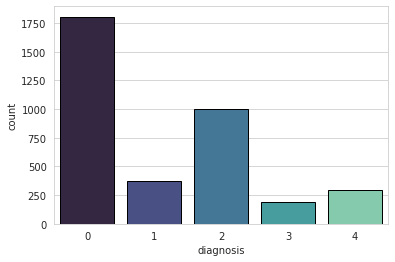

In [ ]:
# check distribution

sns.set_style("whitegrid")
plt.figure(figsize=(6,4))
sns.countplot(x=df_train["diagnosis"], edgecolor="black", palette="mako")

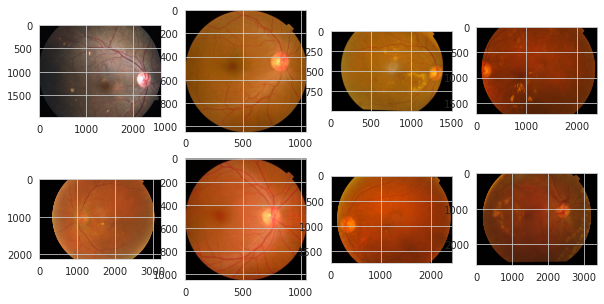

In [ ]:
# check images

# set up the canvas for the subplots
plt.figure(figsize=(10,5))

# Our subplot will contain 2 rows and 4 columns
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)  
    image = train_list[i]    
    # display the image
    plt.imshow(plt.imread(train_path + image))

In [ ]:
def binary_target(x):
    if x != 0:
        return 1
    else:
        return x
    
df_train['binary_target'] = df_train['diagnosis'].apply(binary_target)

In [ ]:
df_train.head()

,id_code,diagnosis,file_name,binary_target
0,000c1434d8d7,2,000c1434d8d7.png,1
1,001639a390f0,4,001639a390f0.png,1
2,0024cdab0c1e,1,0024cdab0c1e.png,1
3,002c21358ce6,0,002c21358ce6.png,0
4,005b95c28852,0,005b95c28852.png,0


In [ ]:
# Check the target distribution

df_train['binary_target'].value_counts()

1    1857
0    1805
Name: binary_target, dtype: int64

In [ ]:
# balance distribution of classes, so that number of images across classes approx same

df_0 = df_train[df_train['binary_target'] == 0]
df_1 = df_train[df_train['binary_target'] == 1].sample(len(df_0), random_state=101)


df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)

print(df_data.shape)

df_data.head()

(3610, 4)


,id_code,diagnosis,file_name,binary_target
36,070d4ce5fd90,0,070d4ce5fd90.png,0
1098,a07efb1ecfc0,0,a07efb1ecfc0.png,0
2873,3a6e9730b298,4,3a6e9730b298.png,1
3491,36677b70b1ef,1,36677b70b1ef.png,1
1549,dd90c321d7bc,0,dd90c321d7bc.png,0


In [ ]:
# Check the new target distribution

df_data['binary_target'].value_counts()

1    1805
0    1805
Name: binary_target, dtype: int64

In [ ]:
# train-test split

df_train, df_val = train_test_split(df_data, test_size=0.1, random_state=101)

print(df_train.shape)
print(df_val.shape)

(3249, 4)
(361, 4)


In [ ]:
# check the train set target distribution
df_train['binary_target'].value_counts()

0    1632
1    1617
Name: binary_target, dtype: int64

In [ ]:
# check the train set target distribution
df_val['binary_target'].value_counts()

1    188
0    173
Name: binary_target, dtype: int64

## transfer images intro appropraite directories for tensorflow ImageGen 

In [ ]:
%cd '/content/drive/MyDrive/Data science/Tensorflow/Projects/diabetic blindness/data/'

/content/drive/MyDrive/Data science/Tensorflow/Projects/diabetic blindness/data


In [ ]:
%pwd

'/content/drive/MyDrive/Data science/Tensorflow/Projects/diabetic blindness/data'

In [ ]:
# path of directories
base_dir = 'base_dir'
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')

a_0 = os.path.join(train_dir, 'a_0')
b_1 = os.path.join(train_dir, 'b_1')

a_0 = os.path.join(val_dir, 'a_0')
b_1 = os.path.join(val_dir, 'b_1')

print(a_0)

base_dir/val_dir/a_0


In [ ]:
# only execute if directories not created yet


# Create directory
os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(val_dir)

# Inside each folder we create seperate folders for each class
# create new folders inside train_dir

os.mkdir(a_0)
os.mkdir(b_1)

# create new folders inside val_dir
os.mkdir(a_0)
os.mkdir(b_1)

FileExistsError: ignored

In [ ]:
# Check that the folders exist
os.listdir('base_dir') + os.listdir(train_dir) +  os.listdir(val_dir)

['train_dir', 'val_dir', 'a_0', 'b_1', 'a_0', 'b_1']

In [ ]:
# need to set the file_name as the index in df_data
df_data.set_index('file_name', inplace=True)

In [ ]:
df_data.head()

,id_code,diagnosis,binary_target
file_name,,,
236f56771ec6.png,236f56771ec6,2,1
65a7fe9482fe.png,65a7fe9482fe,0,0
0318598cfd16.png,0318598cfd16,4,1
012a242ac6ff.png,012a242ac6ff,2,1
e499434242cc.png,e499434242cc,2,1


In [ ]:
df_train.head()

,id_code,diagnosis,file_name,binary_target
349,35beb47fe159,0,35beb47fe159.png,0
1272,b5e6ae31493c,0,b5e6ae31493c.png,0
3427,7b49041cbf17,3,7b49041cbf17.png,1
967,8ee50c26fc13,0,8ee50c26fc13.png,0
1632,e893e86dde94,0,e893e86dde94.png,0


In [ ]:
df_val.head()

,id_code,diagnosis,file_name,binary_target
2368,f72ef9ceeaa8,1,f72ef9ceeaa8.png,1
229,22d843b2bbd1,0,22d843b2bbd1.png,0
128,1509d097b69a,0,1509d097b69a.png,0
1273,b64e1eef3d63,0,b64e1eef3d63.png,0
1192,ab7991df166b,0,ab7991df166b.png,0


In [ ]:
len(list(df_train['file_name']))

3249

In [ ]:
# 224 x 224 preferred size for mobilenet input size
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
IMAGE_CHANNELS = 3

In [ ]:
# function for transferring images into directories
# image resizing done at the same time

def transfer_image(loop_list, src_dir, dest_dir):
  for fname in tqdm(loop_list):
    
    label = df_data.loc[fname,'binary_target']
    
    if label == 0:
        sub_folder = 'a_0'
        # source path to image
        src = os.path.join(src_dir , fname)
        # destination path to image
        dst = os.path.join(dest_dir, sub_folder, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)
        
    if label == 1:
        sub_folder = 'b_1'
        # source path to image
        src = os.path.join(src_dir, fname)
        # destination path to image
        dst = os.path.join(dest_dir, sub_folder, fname)
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        cv2.imwrite(dst, image)


In [ ]:
# Get a list of train images from training data
train_list = list(df_train['file_name'])
transfer_image(train_list, train_path, train_dir)


In [ ]:
# Get a list of validation images from training data

val_list = list(df_val['file_name'])
transfer_image(val_list, train_path, val_dir)


100%|██████████| 361/361 [04:45<00:00,  1.27it/s]


In [ ]:
# Check how many images are in the train sub folders

print(len(os.listdir('base_dir/train_dir/a_0')))
print(len(os.listdir('base_dir/train_dir/b_1')))


# Check how many images are in the val sub folders

print(len(os.listdir('base_dir/val_dir/a_0')))
print(len(os.listdir('base_dir/val_dir/b_1')))

1629
1620
176
185


## Set up generators

In [ ]:
# directories
train_path1 = 'base_dir/train_dir'
val_path1 = 'base_dir/val_dir'

#variables
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 5
val_batch_size = 5

# Get the number of train and val steps
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
# Pre-process the input images in the same way as the ImageNet images 
# were pre-processed when they were used to train MobileNet.
datagen = ImageDataGenerator(preprocessing_function= \
    tf.keras.applications.mobilenet.preprocess_input)

train_gen = datagen.flow_from_directory(train_path1,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=train_batch_size)

val_gen = datagen.flow_from_directory(val_path1,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
# We are only going to use this to make a prediction on the val set. That's
# why the path is set as val_path
test_gen = datagen.flow_from_directory(val_path1,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=1,
                                            shuffle=False)

FileNotFoundError: ignored

# Model

## mobilenet pre-trained model

In [ ]:
# create a copy of a mobilenet model

mobile = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [ ]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 2 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(2, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [ ]:
len(model.layers)

89

In [ ]:
# freeze all layers except last 23 layers, or last 3 layers including pooling to dense
for layer in model.layers[:-23]:
    layer.trainable = False


## train model

In [ ]:
# Get the labels that are associated with each index
print(val_gen.class_indices)

{'a_0': 0, 'b_1': 1}


In [ ]:
# Optional dictionary mapping class indices (integers) to a weight (float) value, 
# used for weighting the loss function (during training only). 
# This can be useful to tell the model to "pay more attention" to samples from an under-represented class.

# Here the weights are set to 1 so this is not affecting the model.
# These weights can be changed later, if needed.

class_weights={
    0: 1.0, # Class 0
    1: 1.0, # Class 1
}

In [ ]:
model.compile(Adam(learning_rate=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy])

filepath = "model.h5"

#callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')


reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)

early_stopper = EarlyStopping(monitor="val_categorical_accuracy", 
                      mode="max", 
                      patience=7)

csv_logger = CSVLogger(filename='training_log.csv',
                       separator=',',
                       append=False)
                              
                              
callbacks_list = [checkpoint, reduce_lr, early_stopper, csv_logger]




history = model.fit(train_gen, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=100, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/100
650/650 [==============================] - 590s 889ms/step - loss: 0.2763 - categorical_accuracy: 0.9224 - val_loss: 0.3479 - val_categorical_accuracy: 0.8837

Epoch 00001: val_categorical_accuracy improved from -inf to 0.88366, saving model to model.h5
Epoch 2/100
650/650 [==============================] - 14s 22ms/step - loss: 0.1589 - categorical_accuracy: 0.9538 - val_loss: 0.1731 - val_categorical_accuracy: 0.9391

Epoch 00002: val_categorical_accuracy improved from 0.88366 to 0.93906, saving model to model.h5
Epoch 3/100
650/650 [==============================] - 15s 22ms/step - loss: 0.1392 - categorical_accuracy: 0.9603 - val_loss: 0.1036 - val_categorical_accuracy: 0.9668

Epoch 00003: val_categorical_accuracy improved from 0.93906 to 0.96676, saving model to model.h5
Epoch 4/100
650/650 [==============================] - 14s 22ms/step - loss: 0.1255 - categorical_accuracy: 0.9634 - val_loss: 0.1373 - val_categorical_accuracy: 0.9668

Epoch 00004: val_categorical_a

# Metrics

In [ ]:
# load the training log
df = pd.read_csv('training_log.csv')

# we are monitoring val_loss
best_acc = df['val_categorical_accuracy'].max()

# display the row with the best accuracy
df[df['val_categorical_accuracy'] == best_acc ].iloc[:3]

,epoch,categorical_accuracy,loss,lr,val_categorical_accuracy,val_loss
11,11,0.994152,0.019433,0.0025,0.99723,0.032595
12,12,0.993536,0.024247,0.0025,0.99723,0.023786
13,13,0.995691,0.015562,0.0025,0.99723,0.032246


In [ ]:
# Here the best epoch will be used.
model.load_weights('model.h5')

val_loss, val_categorical_accuracy = \
model.evaluate_generator(test_gen, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_categorical_accuracy:', val_categorical_accuracy)

val_loss: 0.03259490802884102
val_categorical_accuracy: 0.9972299337387085


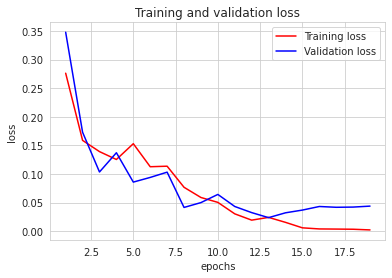

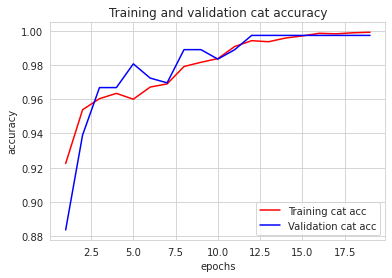

<Figure size 432x288 with 0 Axes>

In [ ]:
# training curves


acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r',label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.figure()


plt.plot(epochs, acc, 'r', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.figure()


plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from itertools import cycle
from scipy import interp

from sklearn.metrics import (classification_report, confusion_matrix, 
                             precision_recall_curve, average_precision_score,
                             roc_curve, auc, roc_auc_score, f1_score, accuracy_score)
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     cross_validate, StratifiedKFold, KFold)
from sklearn.utils import shuffle

In [ ]:
# confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
test_labels = test_gen.classes
test_gen.class_indices


{'a_0': 0, 'b_1': 1}

In [ ]:
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

361/361 [==============================] - 3s 6ms/step


Confusion matrix, without normalization
[[175   1]
 [  0 185]]


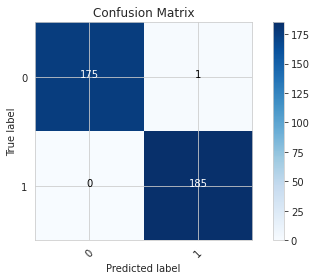

In [ ]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
cm_plot_labels = ['0', '1']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
# classification report

# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_gen.classes

In [ ]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       176
           1       0.99      1.00      1.00       185

    accuracy                           1.00       361
   macro avg       1.00      1.00      1.00       361
weighted avg       1.00      1.00      1.00       361



# predict

In [ ]:
df_test = pd.read_csv(test_csv)
df_test['file_name'] = df_test['id_code'].apply(lambda x: str(x) + '.png')
df_test.head()

NameError: ignored

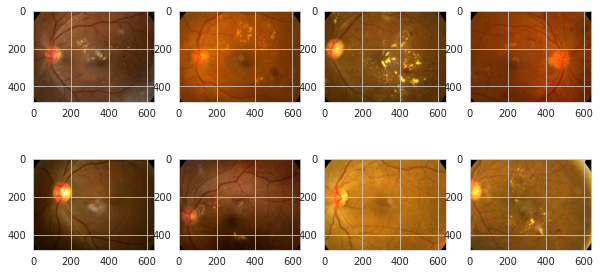

In [ ]:
# check images

# set up the canvas for the subplots
plt.figure(figsize=(10,5))

# Our subplot will contain 2 rows and 4 columns
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)  
    image = test_list[i]    
    # display the image
    plt.imshow(plt.imread(test_path + image))

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image


# uploaded = files.upload()

for i in range(8):
 
  # predicting images
  path = df_test['file_name'][i]
  img = image.load_img( test_path + path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  # print(fn)
  print(classes)

NameError: ignored

# Convert model to js

In [ ]:
! pip install tensorflowjs

     |████████████████████████████████| 71kB 5.2MB/s 


In [ ]:
!mkdir -p saved_model

In [ ]:
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
! ls saved_model/my_model/

assets	keras_metadata.pb  saved_model.pb  variables


In [ ]:
%cd '/content/drive/MyDrive/Data science/Tensorflow/Projects/diabetic blindness/data/'

/content/drive/MyDrive/Data science/Tensorflow/Projects/diabetic blindness/data


In [ ]:
# command line method

! tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_node_names='MobilenetV1/Predictions/Reshape_1' \
    --saved_model_tags=serve \
    ./saved_model/my_model \
    ./diabetic_tfjs

2021-07-03 22:45:25.872378: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-03 22:45:27.380033: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-03 22:45:27.385716: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-03 22:45:27.386112: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2021-07-03 22:45:27.386150: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-03 22:45:27.393277: I tensorflow/stream_executor/platform/default

In [ ]:
!ls 'diabetic_tfjs'

group1-shard1of4.bin  group1-shard3of4.bin  model.json
group1-shard2of4.bin  group1-shard4of4.bin


# Baseline models
